In [7]:
# library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor

from slice_ojh import split_stock, split_mm
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [4]:
x = np.load('x_data.npy', allow_pickle = 'True')

In [5]:
# data preprocess
def prepro(data, method):
    if method == 'minmax':
        scaler = MinMaxScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'stand':
        scaler = StandardScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'robust':
        scaler = RobustScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)

### Xgboost

(554, 25) (554, 3)
(498, 25) (498, 3)
(56, 25) (56, 3)


C:\Users\ILIFO-028\venv\lib\site-packages\xgboost\core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


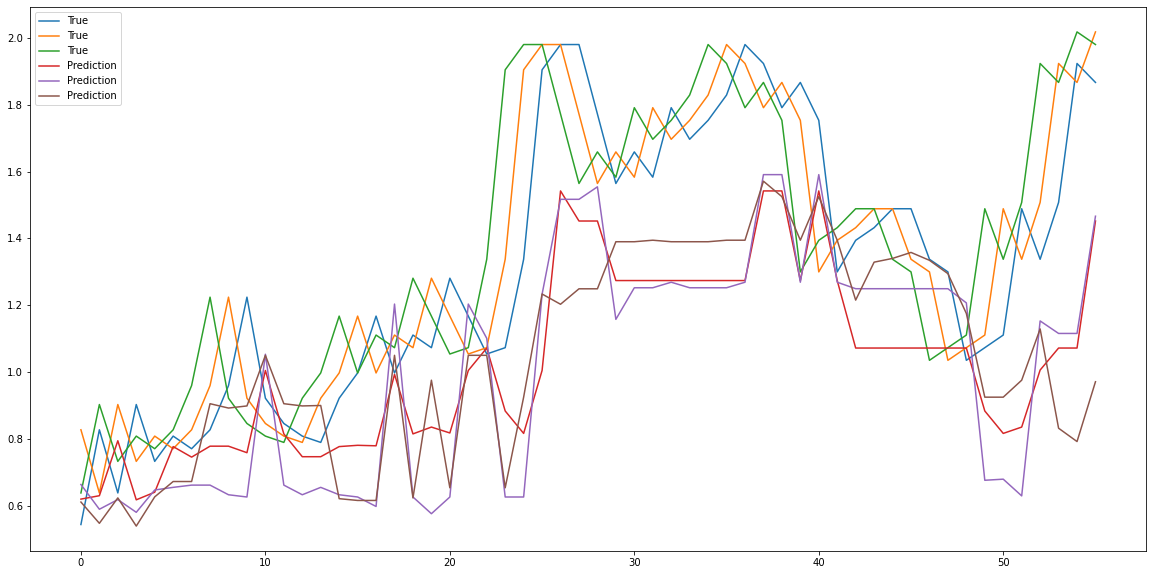

In [9]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

# close data
features, labels = split_mm(x_stand, 25, 3)
print(features.shape, labels.shape)

# split data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# training Xgboost
xgb = XGBRegressor(learning_rate=0.01, n_estimators=100, max_depth=5, random_state=3)
wrapper = MultiOutputRegressor(xgb)
xgb_fit = wrapper.fit(x_train, y_train)

# predict
xgb_pred = wrapper.predict(x_test)

# plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(xgb_pred, label='Prediction')
ax.legend()
plt.show()

In [10]:
# Xgboost hyperparameter
params = {
    'learning_rate':[0.01,0.05,0.1,0.15,0.2],
    'n_estimators':[50,100,150,200],
    'max_depth':[3,5,7,9],
    'subsample':[0.6,0.8,1.0],
    'min_child_weight':[1,5,10],
    'gamma':[0.5,1,1.5,2],
    'max_delta_step':[1,3,5,7,9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'colsample_bytree':[0.6,0.7,0.8,0.9,1.0]}
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(wrapper, params, cv=time_cv)
best_xgb = search.fit(x_train, y_train, verbose=2)
best_param = search.best_params_
print(best_xgb)
print(best_param)

best_pred = best_xgb.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

ValueError: Invalid parameter subsample for estimator MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.01,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=3, reg_alpha=None,
                                            reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None)). Check the list of available parameters with `estimator.get_params().keys()`.

In [146]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

In [147]:
# today close
x_today = x_stand[-25:]
x_today = x_today[np.newaxis,:]
tmp = best_xgb.predict(x_today)
print(tmp)
pred_today = scaler.inverse_transform(tmp)
print(pred_today)

[1.9366989]
[58773.414]


In [148]:
# atfer 2day
x_today2 = x_stand[-24:]
x_today2 = np.append(x_today2, tmp)
x_today2 = x_today2[np.newaxis,:]
tmp2= best_xgb.predict(x_today2)
print(tmp2)
pred_today2 = scaler.inverse_transform(tmp2)
print(pred_today2)

[2.002194]
[59120.46]


In [149]:
# atfer 3day
x_today3 = x_stand[-23:]
x_today3 = np.append(x_today3, tmp)
x_today3 = np.append(x_today3, tmp2)
x_today3 = x_today3[np.newaxis,:]
tmp3 = best_xgb.predict(x_today3)
print(tmp3)
pred_today = scaler.inverse_transform(tmp3)
print(pred_today)

[1.9526659]
[58858.02]


In [83]:
# atfer 4day
x_today4 = x_stand[-22:]
x_today4 = np.append(x_today4, tmp)
x_today4 = np.append(x_today4, tmp2)
x_today4 = np.append(x_today4, tmp3)
x_today4 = x_today4[np.newaxis,:]
tmp3 = best_xgb.predict(x_today4)
print(tmp3)
pred_today = scaler.inverse_transform(tmp3)
print(pred_today)

[1.9923083]
[59068.08]


In [84]:
print(x_today.shape)
print(x_today)
print(x_today4)
print(x_today4.shape)

(1, 25)
[[1.69637652 1.75299332 1.8284824  1.97946054 1.92284374 1.79073786
  1.86622693 1.75299332 1.30005889 1.39442023 1.43216477 1.48878157
  1.48878157 1.33780343 1.30005889 1.03584714 1.07359168 1.11133621
  1.48878157 1.33780343 1.50765384 1.92284374 1.86622693 2.01720508
  1.97946054]]
[[1.97946054 1.92284374 1.79073786 1.86622693 1.75299332 1.30005889
  1.39442023 1.43216477 1.48878157 1.48878157 1.33780343 1.30005889
  1.03584714 1.07359168 1.11133621 1.48878157 1.33780343 1.50765384
  1.92284374 1.86622693 2.01720508 1.97946054 2.01476002 2.01476002
  2.01476002]]
(1, 25)
